In [4]:
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline

import sys
import os


# Add the absolute path to the parent directory of 'src'
sys.path.append(os.path.abspath(os.path.join('..')))

# Now try importing the functions
from src import *


PROJECT_DIR = "../"
TRAJECTORIES_PATH = "data/raw/tables/Trajectories.csv"

In [5]:
df = pd.read_csv(os.path.join(PROJECT_DIR, TRAJECTORIES_PATH))
df

,Frame,shoulder:X,shoulder:Y,shoulder:Z,elbow:X,elbow:Y,elbow:Z,wrist:X,wrist:Y,wrist:Z,ThumbTip:X,ThumbTip:Y,ThumbTip:Z,Sequence
0,1,436.052,6.68681,649.917,466.000,69.3995,320.126,378.086,172.652,101.879,277.110,231.789,58.7156,0
1,2,435.667,6.81775,650.213,465.329,70.5719,320.326,375.730,174.396,102.883,273.667,232.374,58.7935,0
2,3,435.227,7.04491,650.342,464.407,71.5014,320.503,373.477,175.797,103.373,269.956,232.469,59.6211,0
3,4,434.678,7.22860,650.419,463.398,72.4157,320.797,371.195,177.593,105.008,266.502,232.741,60.5555,0
4,5,434.295,7.47742,650.496,462.512,73.5447,320.861,369.178,179.462,107.318,263.200,233.105,62.1383,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29035,448,526.679,230.71500,605.750,577.559,348.9630,304.212,566.061,538.122,124.495,515.664,643.255,31.2370,50
29036,449,526.624,230.63100,605.810,577.474,348.9740,304.370,566.081,538.112,124.613,515.646,643.260,31.2537,50
29037,450,526.565,230.46600,605.832,577.419,349.0540,304.527,566.119,538.113,124.632,515.614,643.216,31.2512,50
29038,451,526.495,230.36500,605.862,577.378,349.0900,304.585,566.148,538.133,124.687,515.603,643.205,31.2383,50


In [6]:
def interpolate_missing_data(df, sequence_col='Sequence'):
    """
    Replaces the very first NaN value in each sequence with the mean of the initial coordinates
    for each joint (column), and returns a new DataFrame without altering the original one.

    Parameters:
    df (pd.DataFrame): The input DataFrame with joint positions.
    sequence_col (str): The name of the column that groups the sequences.

    Returns:
    pd.DataFrame: A new DataFrame with NaNs handled.
    """
    # Create a copy of the original DataFrame to avoid altering it
    new_df = df.copy()

    # Step 1: Calculate the mean of the first coordinates for each joint
    initial_values = df.groupby(sequence_col).apply(lambda X: X.iloc[0]).mean()

    # Step 2: Replace only the very first NaN value of each sequence with the mean
    for col in df.columns:
        if col != sequence_col:  # Ignore the 'Sequence' column
            # Find the first value in each sequence
            first_values = df.groupby(sequence_col)[col].head(1)
            # Identify which first values are NaN
            nan_mask = first_values.isna()
            
            # For sequences where the first value is NaN, replace it with the mean value
            new_df.loc[new_df.groupby(sequence_col).head(1)[nan_mask].index, col] = initial_values[col]

    # Step 3: Apply interpolation for other NaNs if needed
    new_df = new_df.groupby("Sequence").apply(lambda x : x.interpolate(method='linear')).reset_index(drop=True)


    return new_df


In [7]:
df_interpolated = interpolate_missing_data(df)

C:\Users\Trunt\AppData\Local\Temp\ipykernel_19232\2561268091.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  initial_values = df.groupby(sequence_col).apply(lambda X: X.iloc[0]).mean()
C:\Users\Trunt\AppData\Local\Temp\ipykernel_19232\2561268091.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  new_df = new_df.groupby("Sequence").apply(lambda x : x.interpolate(method='linear')).reset_index(drop=True

In [8]:
df_smoothed = apply_kalman_filter_df(df_interpolated, smoothness_factor=0.5)

In [9]:
df_smoothed

,shoulder:X,shoulder:Y,shoulder:Z,elbow:X,elbow:Y,elbow:Z,wrist:X,wrist:Y,wrist:Z,ThumbTip:X,ThumbTip:Y,ThumbTip:Z,Sequence,Frame
0,433.404672,8.352598,650.253436,459.539188,76.928437,321.439097,362.208375,183.430389,109.466809,255.215506,232.744510,64.043300,0,1
1,433.325253,8.402572,650.263529,459.345364,77.154305,321.478490,361.732046,183.753741,109.694443,254.558671,232.773175,64.203131,0,2
2,433.198998,8.484242,650.274632,459.031867,77.511821,321.540933,360.975758,184.264247,110.058306,253.519670,232.809824,64.471155,0,3
3,433.032183,8.594698,650.284389,458.610867,77.989546,321.624134,359.969445,184.944098,110.555876,252.151942,232.853289,64.836180,0,4
4,432.832452,8.732477,650.291453,458.094124,78.578748,321.723878,358.738621,185.770972,111.164402,250.497213,232.899000,65.286818,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29035,526.938126,231.038462,605.470916,577.701777,348.801155,304.003362,566.000554,538.044424,124.353603,515.558694,643.234431,31.072072,50,448
29036,526.910196,230.997078,605.497835,577.679764,348.818443,304.042457,566.008775,538.051794,124.373332,515.562858,643.233846,31.084801,50,449
29037,526.887991,230.963015,605.518512,577.661866,348.832620,304.075002,566.015550,538.057961,124.388268,515.565359,643.232737,31.094153,50,450
29038,526.872245,230.938892,605.532919,577.648825,348.842369,304.098506,566.020257,538.063026,124.398329,515.566887,643.231963,31.100363,50,451


0.5078406994139688


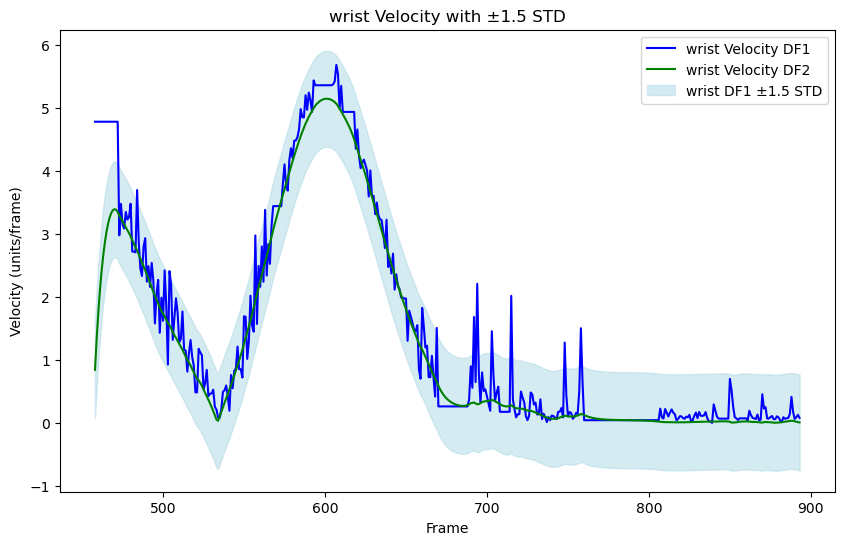

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compute_velocity(df, point):
    # Calculate velocity as the rate of change of the position
    velocity = np.sqrt(
        (df[f'{point}:X'].diff() ** 2) +
        (df[f'{point}:Y'].diff() ** 2) +
        (df[f'{point}:Z'].diff() ** 2)
    )
    return velocity

def compute_std(vel1, vel2):
    # Step 1: Compute the mean

    # Step 2: Compute the squared differences from the mean
    squared_diff = (vel1 - vel2) ** 2

    # Step 3: Sum the squared differences
    sum_squared_diff = np.sum(squared_diff)

    # Step 4: Divide by n-1 (degrees of freedom for a sample)
    variance = sum_squared_diff / (len(vel1) - 1)

    # Step 5: Take the square root to get the standard deviation
    std = np.sqrt(variance)
    print(std)
    return std

def plot_velocity_with_std(df1, df2, point, k=1, sequence=1):
    df1 = df1[df1["Sequence"] == sequence]
    df2 = df2[df2["Sequence"] == sequence]

    # Compute velocities for both DataFrames
    velocity1 = compute_velocity(df1, point)
    velocity2 = compute_velocity(df2, point)

    # Compute standard deviation for both velocities
    std_velocity1 = compute_std(velocity1, velocity2)

    # Set up the x-axis (Frame numbers)
    frames1 = df1.index
    frames2 = df2.index

    # Plot velocities of both data sets
    plt.figure(figsize=(10, 6))
    plt.plot(frames1, velocity1, label=f'{point} Velocity DF1', color='blue')
    plt.plot(frames2, velocity2, label=f'{point} Velocity DF2', color='green')

    # Add filled areas representing ±1 standard deviation
    plt.fill_between(frames1, velocity2 - k*  std_velocity1, velocity2 + k*std_velocity1, 
                     color='lightblue', alpha=0.5, label=f'{point} DF1 ±{k} STD')


    # Labeling the plot
    plt.title(f'{point} Velocity with ±{k} STD')
    plt.xlabel('Frame')
    plt.ylabel('Velocity (units/frame)')
    plt.legend()
    plt.show()
# Example usage: 
# plot_velocities(df1, df2, 'wrist', sequence=3)


plot_velocity_with_std(df_interpolated, df_smoothed, "wrist", k=1.5)

In [11]:
# Updated function to mark outliers for every joint separately
def detect_outliers_per_joint(df, df_smoothed, k=2):
    # Columns to process (excluding Frame and Sequence)
    joint_columns = [col for col in df.columns if col not in ['Frame', 'Sequence']]
    
    # DataFrame to store outlier detection results
    df_outliers = df.copy()
    
    # Initialize outlier flag columns for each joint separately
    for joint in joint_columns:
        df_outliers[f'is_outlier_{joint}'] = False
    
    # Group by sequences to avoid large velocity variances at start/end points of sequences
    for seq, group in df.groupby('Sequence'):
        group_smoothed = df_smoothed[df_smoothed['Sequence'] == seq]
        
        # Loop through each joint coordinate (X, Y, Z for each joint)
        for joint in joint_columns:
            velocity_original = np.gradient(group[joint].to_numpy(), edge_order=2) # Velocity for original data
            velocity_smoothed = np.gradient(group_smoothed[joint].to_numpy(), edge_order=2) # Velocity for smoothed data

            # Calculate standard deviation using the smoothed velocity as the mean
            std = np.sqrt(np.sum((velocity_original - velocity_smoothed) ** 2) / (len(velocity_original) - 1))
            
            # Check for outliers
            outliers = (velocity_original < (velocity_smoothed - k * std)) | (velocity_original > (velocity_smoothed + k * std))
            
            # Mark outliers in the dataframe for the specific joint
            df_outliers.loc[group.index, f'is_outlier_{joint}'] = outliers

    return df_outliers


In [124]:
K = 3

In [125]:
# Visualize the outliers for the wrist joint
df_outliers = detect_outliers_per_joint(df_interpolated, df_smoothed, k=K)
df_outliers

,Frame,shoulder:X,shoulder:Y,shoulder:Z,elbow:X,elbow:Y,elbow:Z,wrist:X,wrist:Y,wrist:Z,...,is_outlier_shoulder:Z,is_outlier_elbow:X,is_outlier_elbow:Y,is_outlier_elbow:Z,is_outlier_wrist:X,is_outlier_wrist:Y,is_outlier_wrist:Z,is_outlier_ThumbTip:X,is_outlier_ThumbTip:Y,is_outlier_ThumbTip:Z
0,1,436.052,6.68681,649.917,466.000,69.3995,320.126,378.086,172.652,101.879,...,True,True,True,False,True,True,False,True,True,False
1,2,435.667,6.81775,650.213,465.329,70.5719,320.326,375.730,174.396,102.883,...,True,True,True,False,True,True,False,True,False,False
2,3,435.227,7.04491,650.342,464.407,71.5014,320.503,373.477,175.797,103.373,...,False,True,True,False,True,True,False,True,False,False
3,4,434.678,7.22860,650.419,463.398,72.4157,320.797,371.195,177.593,105.008,...,False,True,True,False,True,True,True,True,False,False
4,5,434.295,7.47742,650.496,462.512,73.5447,320.861,369.178,179.462,107.318,...,False,True,True,False,True,True,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29035,448,526.679,230.71500,605.750,577.559,348.9630,304.212,566.061,538.122,124.495,...,False,False,False,False,False,False,False,False,False,False
29036,449,526.624,230.63100,605.810,577.474,348.9740,304.370,566.081,538.112,124.613,...,False,False,False,False,False,False,False,False,False,False
29037,450,526.565,230.46600,605.832,577.419,349.0540,304.527,566.119,538.113,124.632,...,False,False,False,False,False,False,False,False,False,False
29038,451,526.495,230.36500,605.862,577.378,349.0900,304.585,566.148,538.133,124.687,...,False,False,False,False,False,False,False,False,False,False


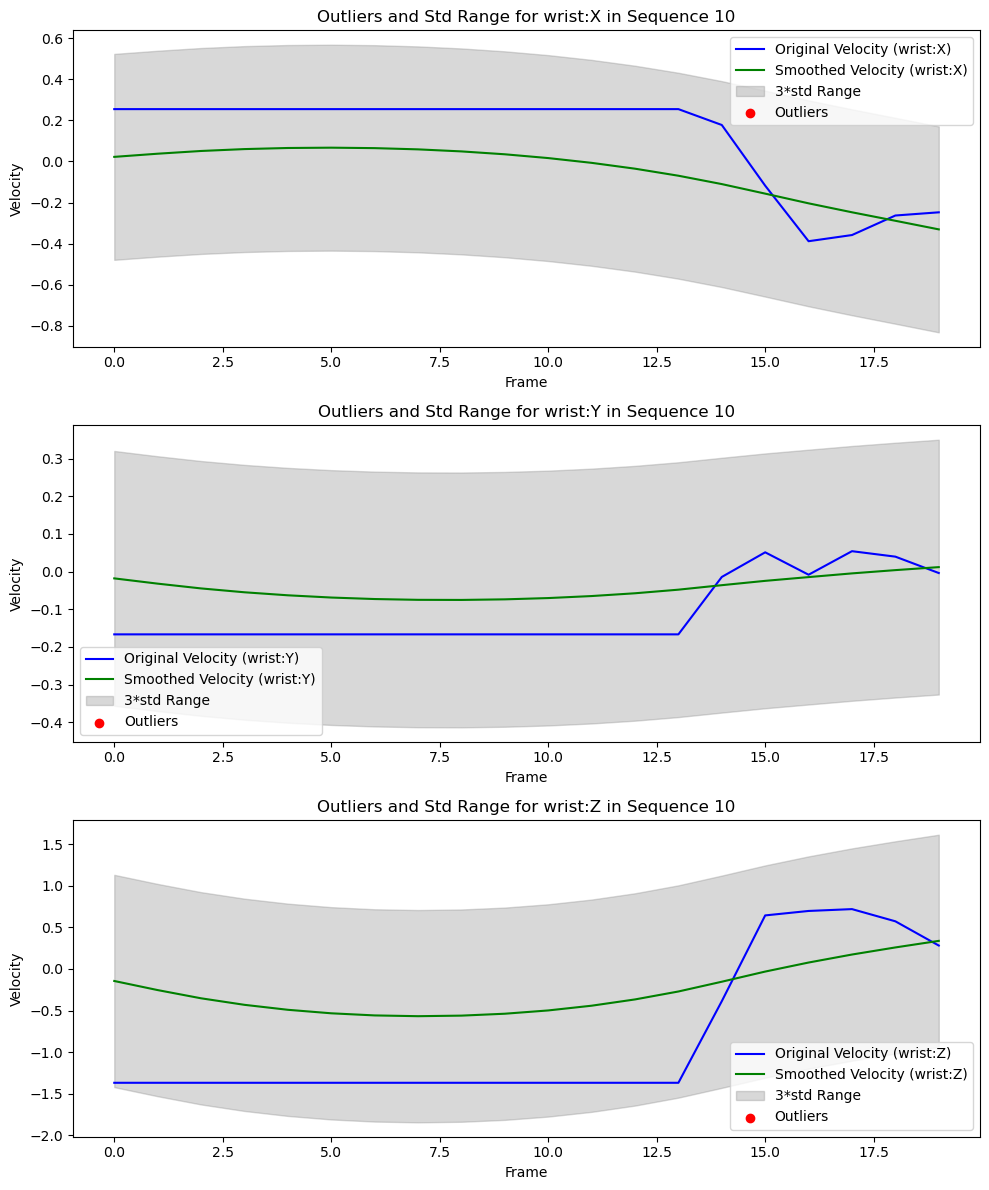

In [131]:
# Updated function to visualize outliers for X, Y, and Z coordinates and include the std range with fill_between
def visualize_outliers(df, df_smoothed, df_outliers, joint, sequence, k=2, max_frames=None):
    # Joint columns (X, Y, Z)
    joint_axes = [f'{joint}:X', f'{joint}:Y', f'{joint}:Z']
    
    # Filter data for the specific sequence
    df_sequence = df[df['Sequence'] == sequence]
    df_smoothed_sequence = df_smoothed[df_smoothed['Sequence'] == sequence]
    df_outliers_sequence = df_outliers[df_outliers['Sequence'] == sequence]
        
    # Create subplots for X, Y, and Z
    fig, axs = plt.subplots(3, 1, figsize=(10, 12))
    axes_labels = ['X', 'Y', 'Z']
    
    for i, axis in enumerate(joint_axes):
        # Extract the original and smoothed velocities for the specific axis
        velocity_original = np.gradient(df_sequence[axis].to_numpy(), edge_order=2)
        velocity_smoothed = np.gradient(df_smoothed_sequence[axis].to_numpy(), edge_order=2)
        
        # Calculate standard deviation using the smoothed velocity as the mean
        std = np.sqrt(np.sum((velocity_original - velocity_smoothed) ** 2) / (len(velocity_original) - 1))

        if max_frames:
            velocity_original = velocity_original[:max_frames]
            velocity_smoothed = velocity_smoothed[:max_frames]
        
        # Plot original and smoothed velocities
        axs[i].plot(velocity_original, label=f'Original Velocity ({joint}:{axes_labels[i]})', color='blue')
        axs[i].plot(velocity_smoothed, label=f'Smoothed Velocity ({joint}:{axes_labels[i]})', color='green')

        # Fill the area between smoothed +/- k*std
        axs[i].fill_between(np.arange(len(velocity_smoothed)),
                            velocity_smoothed - k * std,
                            velocity_smoothed + k * std,
                            color='gray', alpha=0.3, label=f'{k}*std Range')

        # Highlight outliers
        outliers = df_outliers_sequence[f'is_outlier_{axis}']
        if max_frames:
            outliers = outliers[:max_frames]
        outlier_indices = np.where(outliers)[0]
        axs[i].scatter(outlier_indices, velocity_original[outliers], color='red', label='Outliers', zorder=5)
        
        # Add labels and title
        axs[i].set_title(f'Outliers and Std Range for {joint}:{axes_labels[i]} in Sequence {sequence}')
        axs[i].set_xlabel('Frame')
        axs[i].set_ylabel('Velocity')
        axs[i].legend()

    plt.tight_layout()
    plt.show()

# Example usage:
visualize_outliers(df_interpolated, df_smoothed, df_outliers, joint='wrist', sequence=10, k=K, max_frames=50)



In [138]:
# Updated function to detect clustered outliers for all joints automatically
def detect_clustered_outliers(df, df_outliers, window_width=5):
    # Identify all joints based on the column names (exclude 'Frame' and 'Sequence')
    joints = {col.split(':')[0] for col in df.columns if col not in ['Frame', 'Sequence']}
    
    # Loop through each joint and detect clustered outliers for X, Y, and Z axes
    for joint in joints:
        # Joint columns (X, Y, Z)
        joint_axes = [f'{joint}:X', f'{joint}:Y', f'{joint}:Z']
        
        # Create columns for clustered outliers
        for axis in joint_axes:
            df_outliers[f'is_clustered_outlier_{axis}'] = False
        
        # Process each sequence separately
        for seq, group in df.groupby('Sequence'):
            group_outliers = df_outliers[df_outliers['Sequence'] == seq]
            
            # Loop through each axis (X, Y, Z)
            for axis in joint_axes:
                # Compute velocity for the specific axis in this sequence
                velocity = np.gradient(group[axis].to_numpy(), edge_order=2)
                
                # Identify the index and sign of the already detected outliers (based on velocity spikes)
                outlier_indices = np.where(group_outliers[f'is_outlier_{axis}'])[0]
                signs = np.sign(velocity[outlier_indices])
                
                # Initialize index vector X and sign vector S
                X = outlier_indices
                S = signs

                # Identify isolated and clustered outliers
                i = 0
                while i < len(X) - 1:
                    if S[i] != S[i + 1]:  # Check for opposite signs (spike out, spike back)
                        if (X[i + 1] - X[i] == 1):  # Isolated outlier (consecutive frames)
                            # Mark as isolated outlier (already marked by velocity detection)
                            pass
                        elif (X[i + 1] - X[i]) <= window_width:  # Clustered outliers (within window width)
                            # Mark all frames between X[i] and X[i+1] as clustered outliers
                            df_outliers.loc[group.index[X[i]:X[i + 1]], f'is_clustered_outlier_{axis}'] = True
                        i += 2  # Move to the next pair
                    else:
                        i += 1

    return df_outliers



In [153]:
df_outliers_new = detect_clustered_outliers(df_interpolated, df_outliers, window_width=80)

In [154]:
df_outliers_new[["wrist:X", "is_clustered_outlier_wrist:X"]][df_outliers_new["is_clustered_outlier_wrist:X"]]

,wrist:X,is_clustered_outlier_wrist:X
5467,561.759,True
5468,563.855,True
5486,570.013,True
5487,570.345,True
7411,578.089,True
...,...,...
28301,565.785,True
28302,566.966,True
28303,567.416,True
28305,565.895,True


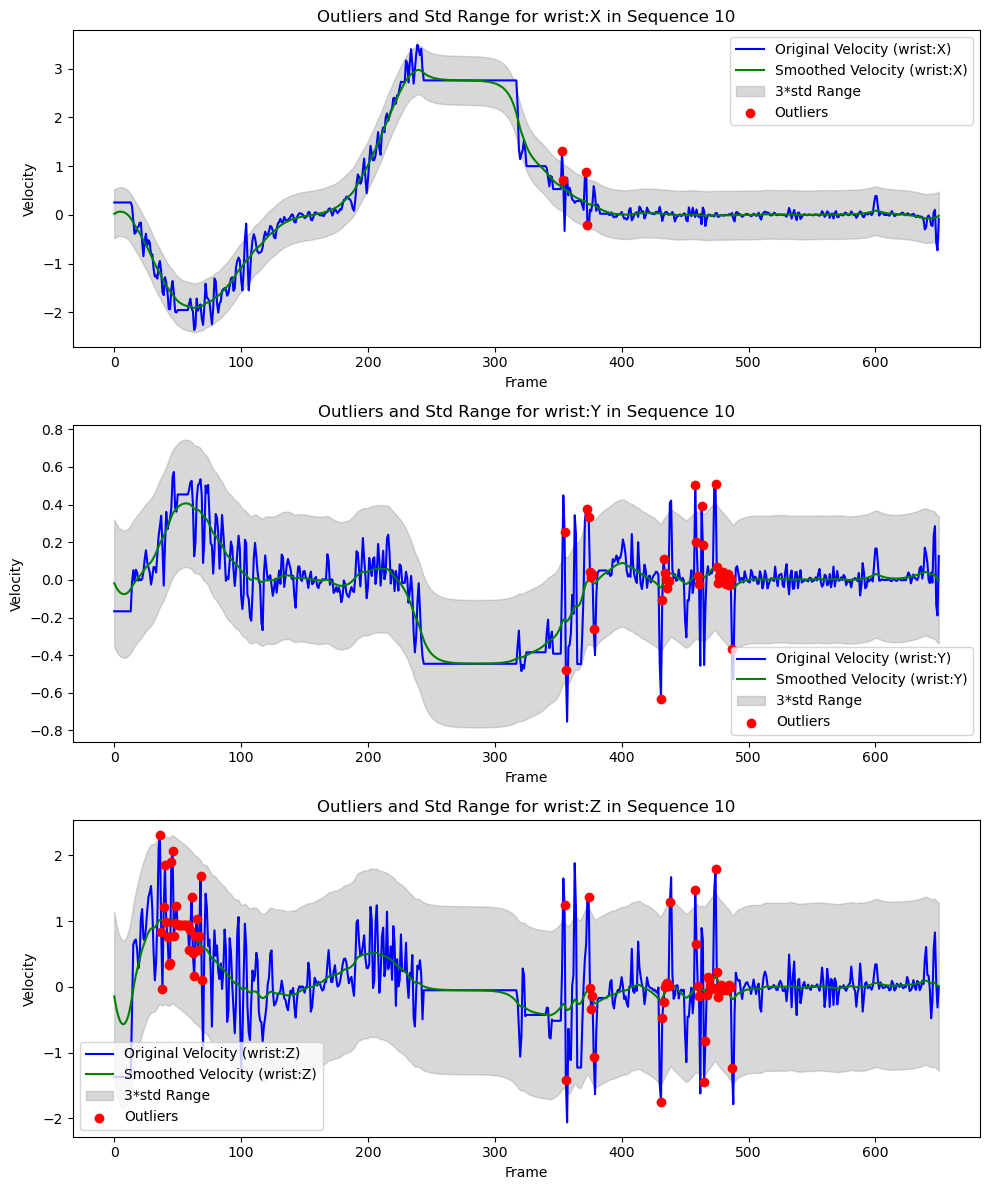

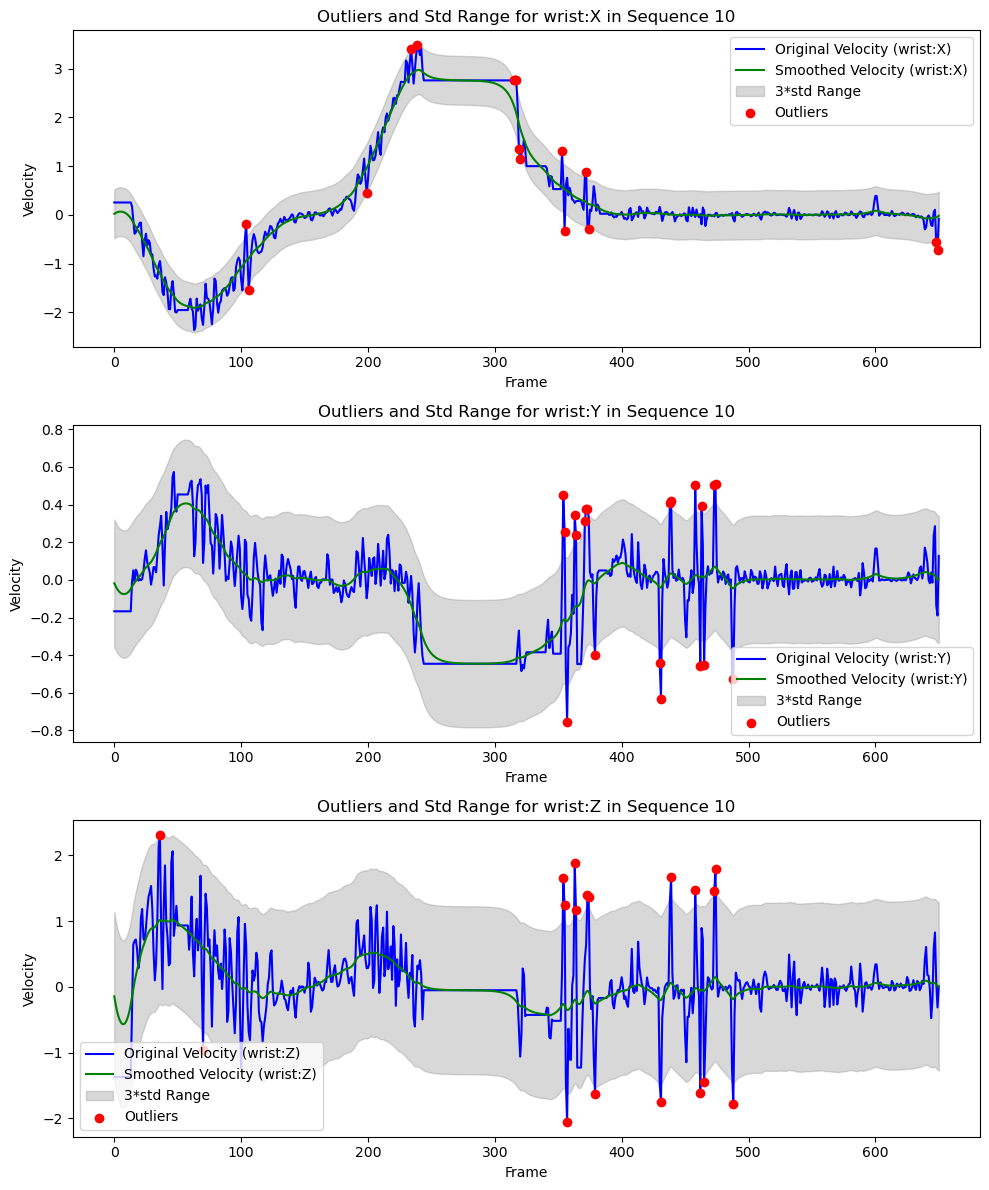

In [158]:
# Updated function to visualize outliers for X, Y, and Z coordinates and include the std range with fill_between
def visualize_outliers_new(df, df_smoothed, df_outliers, joint, sequence, k=2, max_frames=None):
    # Joint columns (X, Y, Z)
    joint_axes = [f'{joint}:X', f'{joint}:Y', f'{joint}:Z']
    
    # Filter data for the specific sequence
    df_sequence = df[df['Sequence'] == sequence]
    df_smoothed_sequence = df_smoothed[df_smoothed['Sequence'] == sequence]
    df_outliers_sequence = df_outliers[df_outliers['Sequence'] == sequence]
    
    # Create subplots for X, Y, and Z
    fig, axs = plt.subplots(3, 1, figsize=(10, 12))
    axes_labels = ['X', 'Y', 'Z']
    
    for i, axis in enumerate(joint_axes):
        # Extract the original and smoothed velocities for the specific axis
        velocity_original = np.gradient(df_sequence[axis].to_numpy(), edge_order=2)
        velocity_smoothed = np.gradient(df_smoothed_sequence[axis].to_numpy(), edge_order=2)
        
        # Calculate standard deviation using the smoothed velocity as the mean
        std = np.sqrt(np.sum((velocity_original - velocity_smoothed) ** 2) / (len(velocity_original) - 1))

        if max_frames:
            velocity_original = velocity_original[:max_frames]
            velocity_smoothed = velocity_smoothed[:max_frames]
        
        # Plot original and smoothed velocities
        axs[i].plot(velocity_original, label=f'Original Velocity ({joint}:{axes_labels[i]})', color='blue')
        axs[i].plot(velocity_smoothed, label=f'Smoothed Velocity ({joint}:{axes_labels[i]})', color='green')

        # Fill the area between smoothed +/- k*std
        axs[i].fill_between(np.arange(len(velocity_smoothed)),
                            velocity_smoothed - k * std,
                            velocity_smoothed + k * std,
                            color='gray', alpha=0.3, label=f'{k}*std Range')

        # Highlight outliers
        outliers = df_outliers_sequence[f'is_clustered_outlier_{axis}']# | df_outliers_sequence[f'is_outlier_{axis}']
        if max_frames:
            outliers = outliers[:max_frames]

        outlier_indices = np.where(outliers)[0]
        axs[i].scatter(outlier_indices, velocity_original[outliers], color='red', label='Outliers', zorder=5)
        
        # Add labels and title
        axs[i].set_title(f'Outliers and Std Range for {joint}:{axes_labels[i]} in Sequence {sequence}')
        axs[i].set_xlabel('Frame')
        axs[i].set_ylabel('Velocity')
        axs[i].legend()

    plt.tight_layout()
    plt.show()

# Example usage:
visualize_outliers_new(df_interpolated, df_smoothed, df_outliers_new, joint='wrist', sequence=10, k=K, max_frames=None)
visualize_outliers(df_interpolated, df_smoothed, df_outliers, joint='wrist', sequence=10, k=K, max_frames=None)




In [159]:
df_correct = df_interpolated.copy()

# print how much data is missing
print(f"Missing data before: {df_correct.isna().sum().sum()}")

# mark outliers as NaN
for col in df_outliers_new.columns:
    if "is_clustered_outlier" in col:
        df_correct.loc[df_outliers_new[col], col.split("_")[-1]] = np.nan
        
print(f"Missing data after: {df_correct.isna().sum().sum()}")

# print the percentage of missing data
print(f"Percentage of missing data: {df_correct.isna().sum().sum() / df_correct.size * 100:.2f}%")

Missing data before: 0
Missing data after: 14237
Percentage of missing data: 3.50%


C:\Users\Trunt\AppData\Local\Temp\ipykernel_19232\953270124.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_correct = df_correct.groupby("Sequence").apply(lambda x : x.interpolate(method='cubic')).reset_index(drop=True)


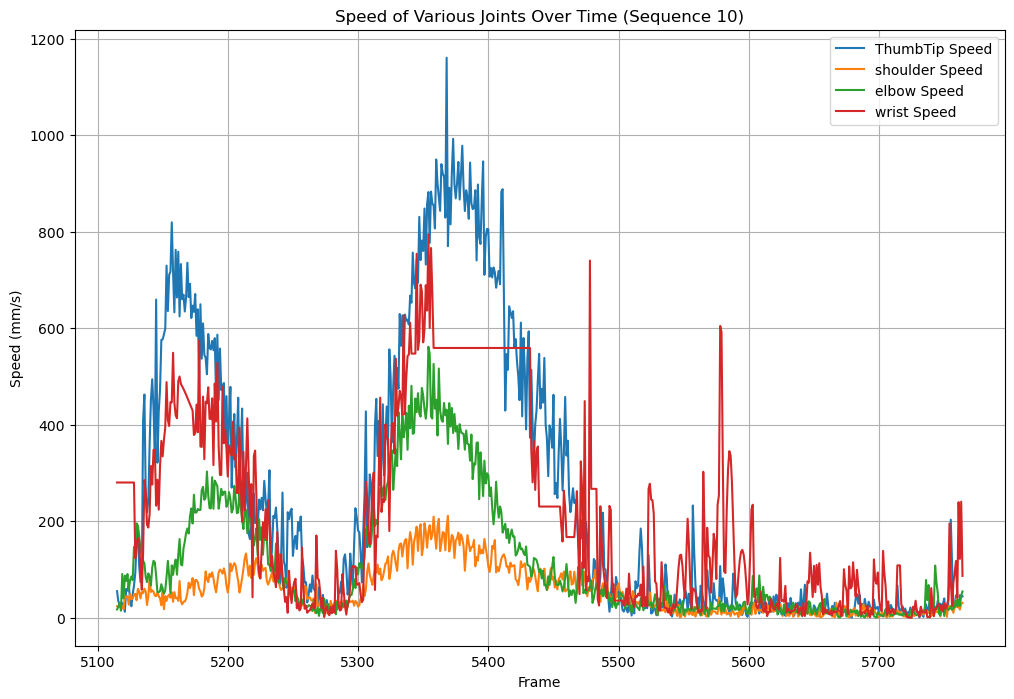

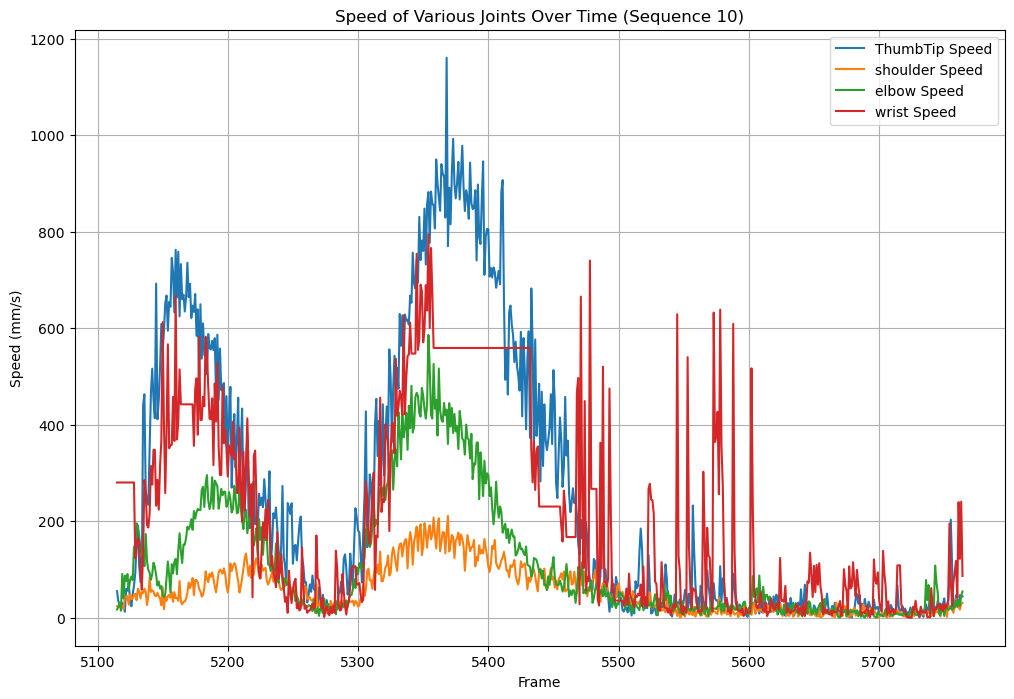

In [160]:
# interpolate the missing data
df_correct = df_correct.groupby("Sequence").apply(lambda x : x.interpolate(method='cubic')).reset_index(drop=True)

# visualize the corrected data
plot_joint_speeds(df_correct, 10)
plot_joint_speeds(df_interpolated, 10)

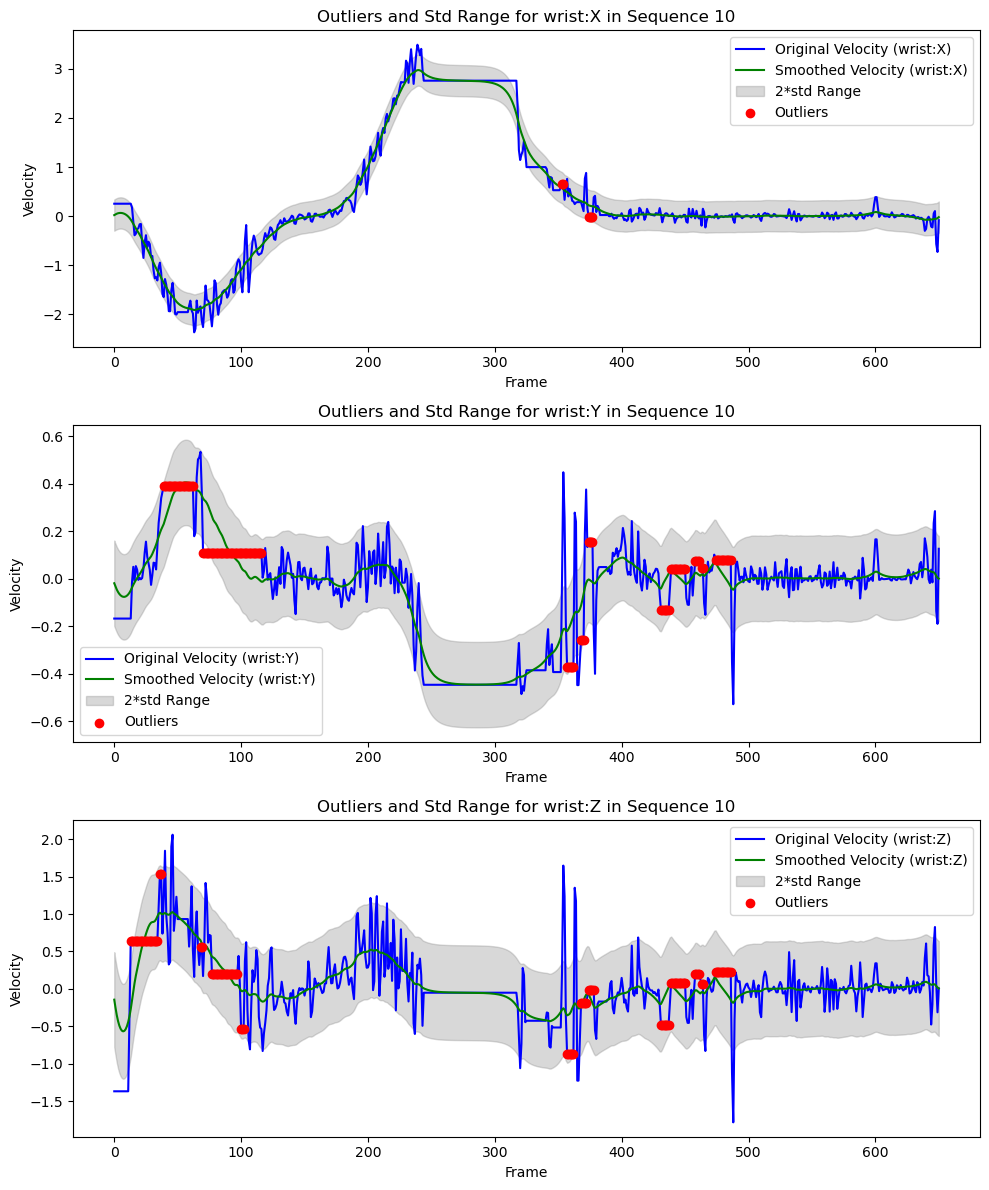

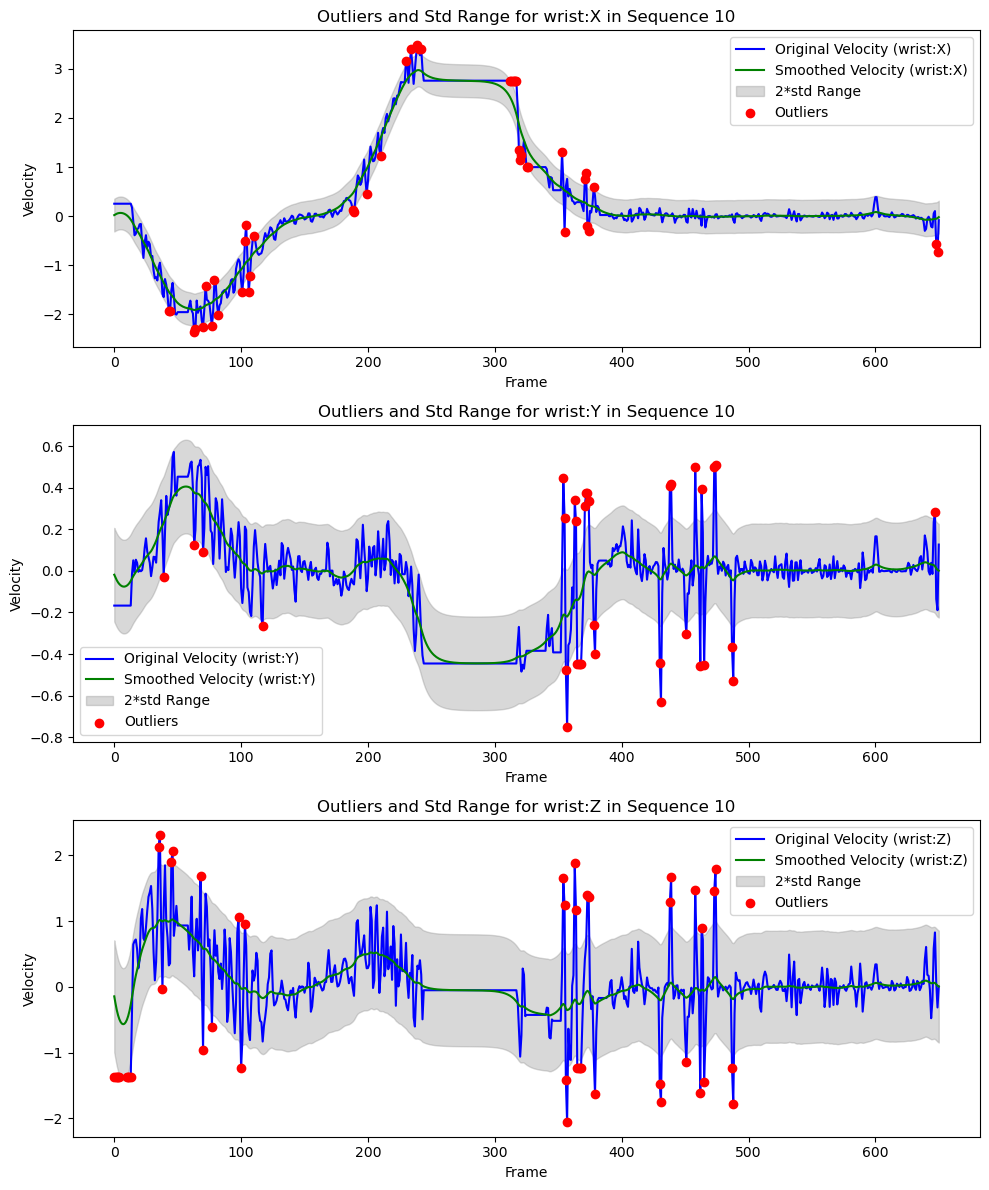

In [106]:
visualize_outliers_new(df_correct, df_smoothed, df_outliers, joint='wrist', sequence=10, k=2)
visualize_outliers(df_interpolated, df_smoothed, df_outliers, joint='wrist', sequence=10, k=2)

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_joint_position_with_and_without_smoothing(df, joint, sequence, smoothness_factor=1):
    """
    Plots the positional data of a specific joint with and without Kalman smoothing.

    Parameters:
        df (pd.DataFrame): The input DataFrame with joint positional data.
        joint (str): The joint to plot (e.g., 'shoulder', 'elbow').
        sequence (int): The sequence to plot.
        smoothness_factor (float): The smoothness factor for Kalman filter.
    """
    # Filter the data for the specified sequence and joint
    joint_columns = [f"{joint}:X", f"{joint}:Y", f"{joint}:Z"]
    sequence_data = df[df['Sequence'] == sequence].dropna(subset=joint_columns)

    # Get observations (X, Y, Z) for the specified joint and sequence
    observations = sequence_data[joint_columns].values

    # Apply Kalman filter to smooth the data
    smoothed_data = apply_kalman_filter_ndarray(observations, smoothness_factor)

    # Plot the original and smoothed data for each dimension (X, Y, Z)
    fig, axs = plt.subplots(3, 1, figsize=(10, 8))
    time_steps = np.arange(len(observations))

    for i, axis in enumerate(['X', 'Y', 'Z']):
        axs[i].plot(time_steps, observations[:, i], label=f'Original {axis}', color='blue', linestyle='dotted')
        axs[i].plot(time_steps, smoothed_data[:, i], label=f'Smoothed {axis}', color='orange', linestyle='solid')
        axs[i].set_title(f'{joint} {axis}-axis: Original vs Smoothed')
        axs[i].set_xlabel('Frame')
        axs[i].set_ylabel('Position')
        axs[i].legend()

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming you have a DataFrame 'df' in the correct format
# plot_joint_position_with_and_without_smoothing(df, joint='shoulder', sequence=1, smoothness_factor=0.5)


In [9]:
df

,Frame,shoulder:X,shoulder:Y,shoulder:Z,elbow:X,elbow:Y,elbow:Z,wrist:X,wrist:Y,wrist:Z,ThumbTip:X,ThumbTip:Y,ThumbTip:Z,Sequence
0,1,436.052,6.68681,649.917,466.000,69.3995,320.126,378.086,172.652,101.879,277.110,231.789,58.7156,0
1,2,435.667,6.81775,650.213,465.329,70.5719,320.326,375.730,174.396,102.883,273.667,232.374,58.7935,0
2,3,435.227,7.04491,650.342,464.407,71.5014,320.503,373.477,175.797,103.373,269.956,232.469,59.6211,0
3,4,434.678,7.22860,650.419,463.398,72.4157,320.797,371.195,177.593,105.008,266.502,232.741,60.5555,0
4,5,434.295,7.47742,650.496,462.512,73.5447,320.861,369.178,179.462,107.318,263.200,233.105,62.1383,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29035,448,526.679,230.71500,605.750,577.559,348.9630,304.212,566.061,538.122,124.495,515.664,643.255,31.2370,50
29036,449,526.624,230.63100,605.810,577.474,348.9740,304.370,566.081,538.112,124.613,515.646,643.260,31.2537,50
29037,450,526.565,230.46600,605.832,577.419,349.0540,304.527,566.119,538.113,124.632,515.614,643.216,31.2512,50
29038,451,526.495,230.36500,605.862,577.378,349.0900,304.585,566.148,538.133,124.687,515.603,643.205,31.2383,50


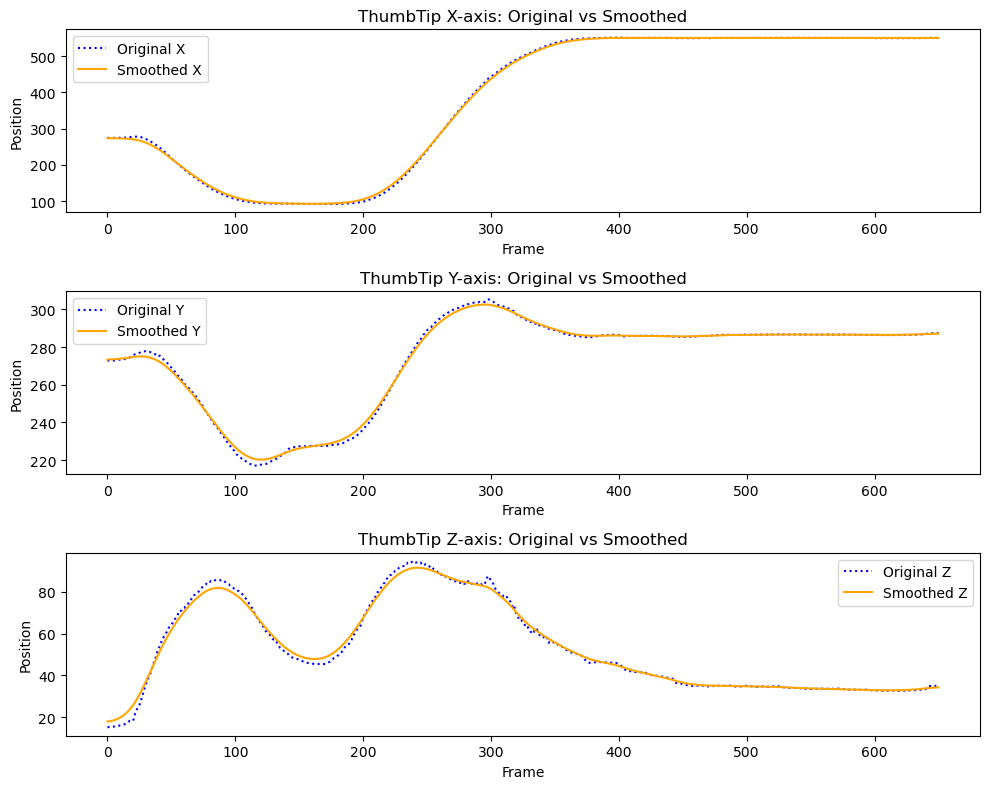

In [11]:
plot_joint_position_with_and_without_smoothing(df_interpolated, joint='ThumbTip', sequence=10, smoothness_factor=1)